In [1]:
!pip install pyLDAvis

In [2]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Load data file
reviews = pd.read_csv("amazon_reviews.csv", index_col="Id")
display(reviews.head())
print(reviews.isna().any())

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool


In [3]:
# Data cleaning
reviews["Time"] = pd.to_datetime(reviews["Time"], unit="s")  # Parse time
reviews["Summary"].fillna("", inplace=True)  # Fill na value for "Summary" column with empty string
reviews["Text"] = reviews["Text"].str.replace("<.+?>", "")  # Remove HTML tags
reviews["HelpfulnessNumerator"] = reviews[["HelpfulnessNumerator", "HelpfulnessDenominator"]].min(axis=1)  # If numerator is greater than denominator, replace with denominator
reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...


# Part I: Descriptive Analysis
In this part of the analysis, you will be exploring some NLP (natural language processing) techniques to better understand the data.

a) Create a __<ins>table</ins>__ that contains information on minimum, average, median, and maximum for the following: review length, summary length, score, helpfulness ratio (helpfulness numerator divided by helpfulness denominator)

In [4]:
reviews["SummaryLength"] = reviews["Summary"].str.split().map(len)
reviews["TextLength"] = reviews["Text"].str.split().map(len)
reviews["HelpfulnessRatio"] = reviews["HelpfulnessNumerator"] / reviews["HelpfulnessDenominator"]
reviews["HelpfulnessRatio"].fillna(0, inplace=True)  # Fill na value (resulted from 0/0) with 0
reviews[["TextLength", "SummaryLength", "Score", "HelpfulnessRatio"]].describe().loc[["min", "mean", "50%", "max"]]

,TextLength,SummaryLength,Score,HelpfulnessRatio
min,3.000000,0.000000,1.000000,0.000000
mean,79.096428,4.113101,4.183199,0.407858
50%,56.000000,4.000000,5.000000,0.000000
max,3377.000000,42.000000,5.000000,1.000000


b) Create __<ins>four line graphs</ins>__ with the following variables aggregated by day over time: review length, summary length, score, helpfulness ratio (helpfulness numerator divided by helpfulness denominator) -- the horizontal axis should correspond to time. Do you observe any patterns or interesting trends?

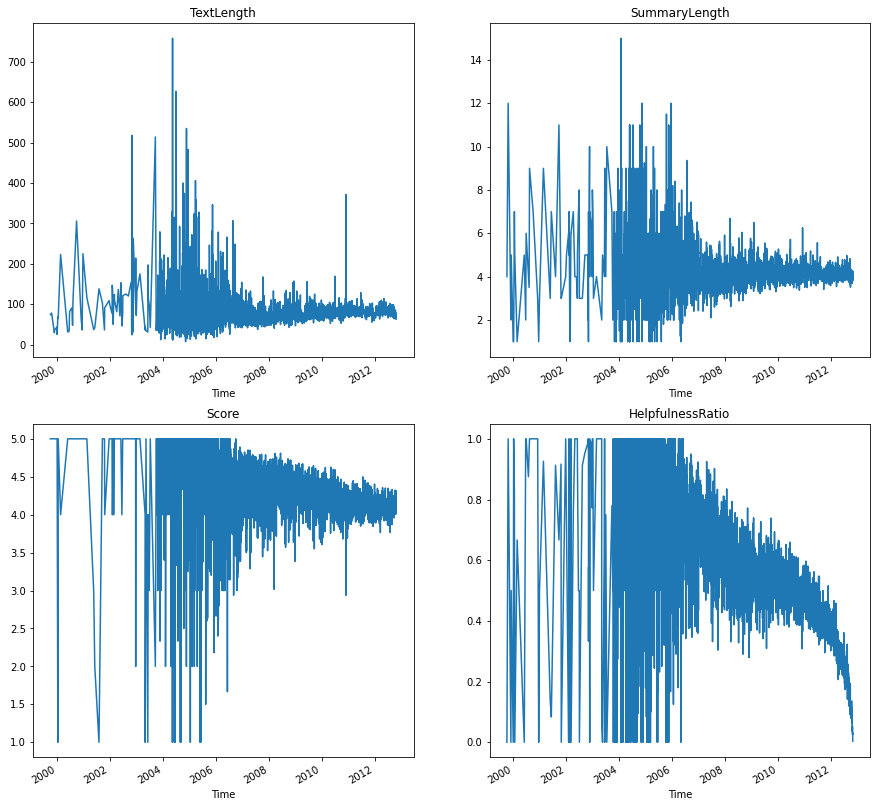

In [5]:
import matplotlib.pyplot as plt

aggregated = reviews[["Time", "TextLength", "SummaryLength", "Score", "HelpfulnessRatio"]].groupby("Time").mean()
plt.figure(figsize=(15, 15))
for i, col in enumerate(aggregated.columns, start=1):
    plt.subplot(2, 2, i)
    aggregated[col].plot()
    plt.title(col)
plt.show()

There were very great fluctuations in average review length, summary length, score, and helpfulness ratio from day to day between 2004 and 2007. After 2007, average review length and summary length remained quite stable, while average score slightly reduced, and average helpfulness ratio fairly dropped, especially after 2010.

c) Using the __lda_tutorial.pdf__ file in the assignment folder, perform a __Latent Dirichlet Allocation (LDA)__ analysis to extract the topics in the __*Text*__ column in an unsupervised manner. Set the number of clusters/topics to __5 (five)__. What are your observations? Does each cluster seem to form a meaningful subset? What do they seem to represent?

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

count_vectorizer = CountVectorizer(stop_words="english")
count_data = count_vectorizer.fit_transform(reviews["Text"])
words = count_vectorizer.get_feature_names()
lda = LDA(n_components=5, n_jobs=-1, random_state=12345)
lda.fit(count_data)

print("Topics found via LDA:")
for topic_idx, topic in enumerate(lda.components_):
    print("\nTopic #%d:" % topic_idx)
    print(" ".join(words[i] for i in topic.argsort()[:-11:-1]))

Topics found via LDA:

Topic #0:
food dog like eat dogs treats love loves just good

Topic #1:
tea flavor like coffee taste good chocolate just cup drink

Topic #2:
like good taste great just flavor love chips salt really

Topic #3:
coffee amazon product price good great order just buy box

Topic #4:
product water like sugar use taste oil just good bottle


In [7]:
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis

LDAvis_data_filepath = "./ldavis_prepared_5"
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, "rb") as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, "./ldavis_prepared_5.html")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Part II: Model Creation and Prediction
For this part of the analysis, you will need to create a model that predicts the __*Score*__ column of your dataset, report the __accuracy__ of your model, and the __confusion matrix__ that you create. __You will mainly be graded on the RMSE (root-mean squared error) of your model__. Some guidelines:

+ You can <ins>only</ins> use the following prediction models, and report on the best model:
  + __Linear regression, Ridge regression, Lasso regression__
+ You can use the following dimension reduction methods:
  + __PCA, t-SNE, spectral embedding__
  + You can use these techniques in any combination (applying them in any order you would like)
+ You are free to use and transform any column of the dataset you would like. Some potential transformations that you can try (you are also welcome to try others):
  + Weighting some of the observations
  + Grouping the observations by a particular characteristic
  + Doing a logarithmic or polynomial transformation
+ You are free to create a new column (a stream of data) based on the existing columns and use your new column as an independent variable. Some possible ideas:
  + Converting the review text into numerical values using the NLTK sentiment analysis package
  + Reducing the dimensionality of your dataset through a linear combination of some columns

In [8]:
# Split training and testing sets
sample_submission = pd.read_csv("sampleSubmission.csv", index_col="Id")
test = reviews.loc[sample_submission.index]
train = reviews.loc[~reviews.index.isin(sample_submission.index)]

In [9]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download(["punkt", "stopwords", "wordnet"])
STOPWORDS = stopwords.words("english")
LMTZR = WordNetLemmatizer()

def process_text(review):
    summary, text = review["Summary"], review["Text"]
    text = " ".join((summary, text))  # join summary and text together
    text = re.sub("[^A-Za-z]", " ", text.lower())  # convert to lower case and remove non-alphabetic
    tokenized_text = word_tokenize(text)  # tokenize
    clean_text = (LMTZR.lemmatize(word) for word in tokenized_text if word not in STOPWORDS)  # remove stopwords and lemmatize to root form
    return " ".join(clean_text)

# Process and vectorize text
train_text = train.apply(process_text, axis=1)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=300)
train_vectors = vectorizer.fit_transform(train_text)

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
from sklearn.decomposition import PCA

# PCA to reduce dimensionality
pca = PCA(0.8, random_state=31415)
reduced = pca.fit_transform(train_vectors.toarray())
print("Number of components:", pca.n_components_)
pc1 = pd.Series(pca.components_[0,:], index=vectorizer.get_feature_names())
pc1.sort_values(ascending=False, inplace=True)
pc1

Number of components: 188


coffee    0.594407
tea       0.449581
cup       0.227176
flavor    0.101285
taste     0.090626
            ...   
love     -0.095695
cat      -0.159787
treat    -0.175367
food     -0.245504
dog      -0.359603
Length: 300, dtype: float64

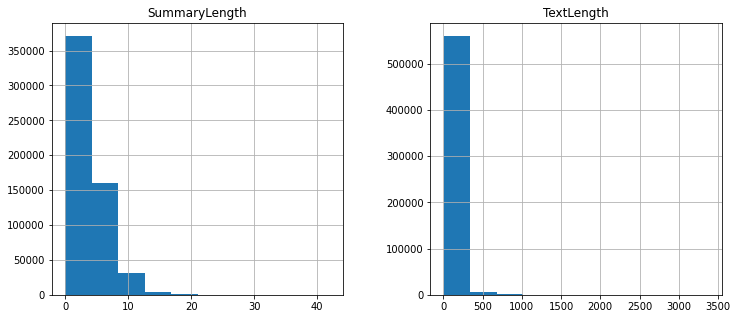

In [11]:
# Histograms for summary/text lengths
reviews[["SummaryLength", "TextLength"]].hist(figsize=(12, 5))
plt.show()

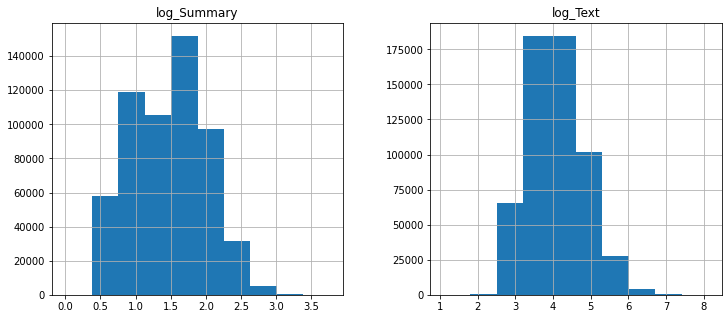

In [12]:
# Histograms for log-transformed summary/text lengths
reviews["log_Summary"] = reviews["SummaryLength"].apply(np.log1p)
reviews["log_Text"] = reviews["TextLength"].apply(np.log)
reviews[["log_Summary", "log_Text"]].hist(figsize=(12, 5))
plt.show()

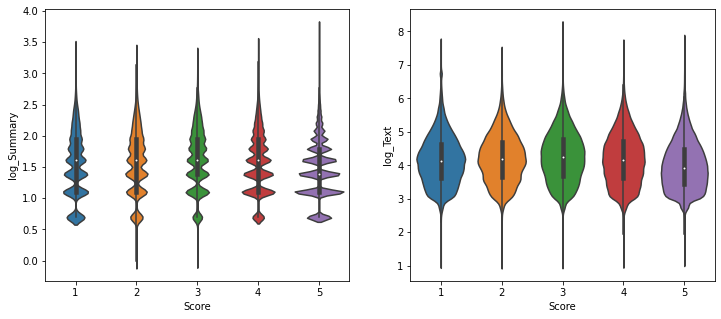

In [13]:
import seaborn as sns

# Violin plots for relationship between scores and summary/text lengths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.violinplot(x="Score", y="log_Summary", data=reviews)
plt.subplot(1, 2, 2)
sns.violinplot(x="Score", y="log_Text", data=reviews)
plt.show()

In [14]:
# Training data for linear regression model input
X_train = pd.DataFrame(reduced, index=train.index,
                       columns=["PC {}".format(i) for i in range(1, pca.n_components_ + 1)])
X_train["YrAfter2007"] = train["Time"].dt.year.map(lambda yr: max(yr - 2007, 0))
X_train["log_Summary"] = train["SummaryLength"].apply(np.log1p)
X_train["log_Text"] = train["TextLength"].apply(np.log)

# Testing data for linear regression model input
test_text = test.apply(process_text, axis=1)
test_vectors = vectorizer.transform(test_text)
X_test = pd.DataFrame(pca.transform(test_vectors.toarray()), index=test.index,
                      columns=["PC {}".format(i) for i in range(1, pca.n_components_ + 1)])
X_test["YrAfter2007"] = test["Time"].dt.year.map(lambda yr: max(yr - 2007, 0))
X_test["log_Summary"] = test["SummaryLength"].apply(np.log1p)
X_test["log_Text"] = test["TextLength"].apply(np.log)

In [15]:
# Weight the training data: depend on helpfulness, if numerator > 0 then weight = numerator ^ ratio, otherwise weight = 1
weights = train.apply(lambda row: row["HelpfulnessNumerator"] ** row["HelpfulnessRatio"] if row["HelpfulnessNumerator"] else 1, axis=1)

In [16]:
# Alternative weighting based on inverse ratio of target frequencies
score_freq = train["Score"].value_counts(normalize=True)
weights_alt = train["Score"].apply(lambda score: 1 / score_freq[score])

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

def predict_score(model, input_data):
    pred = model.predict(input_data)
    pred = np.round(pred).astype(int)  # round to the nearest integer
    pred = np.where(pred < 1, 1, pred)  # fix to 1 if output < 1
    pred = np.where(pred > 5, 5, pred)  # fix to 5 if output > 5
    return pred

# Try simple linear regression
lr = LinearRegression()
lr.fit(X_train, train["Score"], weights)
lr_pred = predict_score(lr, X_test)
lr_cm = pd.DataFrame(confusion_matrix(test["Score"], lr_pred),
                     index=range(1, 6), columns=range(1, 6))
display(lr_cm)
print("Accuracy:", accuracy_score(test["Score"], lr_pred))
print("RMSE:", mean_squared_error(test["Score"], lr_pred, squared=False))

,1,2,3,4,5
1,185,1404,4771,2844,143
2,38,463,2323,2194,185
3,20,356,2639,3802,515
4,10,136,2313,8271,3463
5,9,190,4133,28914,30679


Accuracy: 0.42237
RMSE: 1.1008269618791138


In [18]:
# Alternative weighting
lr2 = LinearRegression()
lr2.fit(X_train, train["Score"], weights_alt)
lr2_pred = predict_score(lr2, X_test)
lr2_cm = pd.DataFrame(confusion_matrix(test["Score"], lr2_pred),
                      index=range(1, 6), columns=range(1, 6))
display(lr2_cm)
print("Accuracy:", accuracy_score(test["Score"], lr2_pred))
print("RMSE:", mean_squared_error(test["Score"], lr2_pred, squared=False))

,1,2,3,4,5
1,958,4747,3337,285,20
2,213,2054,2570,344,22
3,118,1851,4205,1064,94
4,28,1225,6963,5030,947
5,63,2367,21389,29182,10924


Accuracy: 0.23171
RMSE: 1.3386971278074813


In [19]:
# Try unweighted samples
lr3 = LinearRegression()
lr3.fit(X_train, train["Score"])
lr3_pred = predict_score(lr3, X_test)
lr3_cm = pd.DataFrame(confusion_matrix(test["Score"], lr3_pred),
                      index=range(1, 6), columns=range(1, 6))
display(lr3_cm)
print("Accuracy:", accuracy_score(test["Score"], lr3_pred))
print("RMSE:", mean_squared_error(test["Score"], lr3_pred, squared=False))

,1,2,3,4,5
1,133,1199,4767,3109,139
2,32,376,2385,2268,142
3,11,293,2583,3983,462
4,5,108,2096,8672,3312
5,7,113,3410,29535,30860


Accuracy: 0.42624
RMSE: 1.0935995610825746


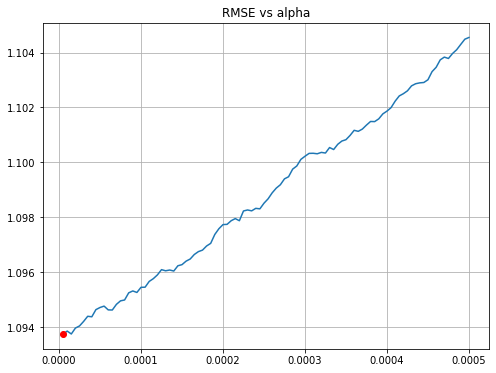

In [20]:
from sklearn.linear_model import Lasso

# Try Lasso regression
alphas = np.linspace(0.000005, 0.0005, 100)
rmses = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, train["Score"])
    lasso_pred = predict_score(lasso, X_test)
    rmses.append(mean_squared_error(test["Score"], lasso_pred, squared=False))

i = np.argmin(rmses)
plt.figure(figsize=(8, 6))
plt.plot(alphas, rmses)
plt.plot([alphas[i]], rmses[i], "ro")
plt.grid()
plt.title("RMSE vs alpha")
plt.show()

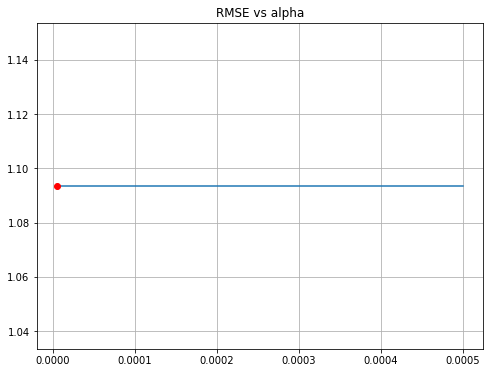

In [21]:
from sklearn.linear_model import Ridge

# Try Ridge regression
alphas = np.linspace(0.000005, 0.0005, 100)
rmses = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, train["Score"])
    ridge_pred = predict_score(ridge, X_test)
    rmses.append(mean_squared_error(test["Score"], ridge_pred, squared=False))

i = np.argmin(rmses)
plt.figure(figsize=(8, 6))
plt.plot(alphas, rmses)
plt.plot([alphas[i]], rmses[i], "ro")
plt.grid()
plt.title("RMSE vs alpha")
plt.show()

In [22]:
sample_submission["Predicted"] = lr3_pred
sample_submission

,Predicted
Id,
413937,4
16525,4
221883,4
82207,5
8354,4
...,...
425070,3
42867,4
320644,3


In [23]:
sample_submission.to_csv("submission.csv")